**Load packages**

In [84]:
from planar_utils import load_extra_datasets, plot_decision_boundary
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()
X, Y = noisy_moons
print(X.shape)
print(Y.shape)

(200, 2)
(200,)


**reshape Y and transpose data to (nx,m) shape where m is nb of examples**

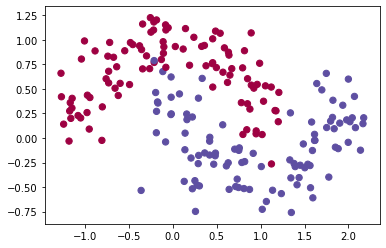

In [86]:
X = X.T
Y = Y.reshape(1, Y.shape[0])

plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

## Neural network schema

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

In [87]:
def layer_sizes(X, Y):
    n_x = X.shape[0]
    n_y = Y.shape[0]
    n_h = 4
    
    return (n_x, n_h, n_y)

In [88]:
def initialte_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [89]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [90]:
def forward_propagation(X, parameters):
    W1 = parameters.get('W1')
    b1 = parameters.get('b1')
    W2 = parameters.get('W2')
    b2 = parameters.get('b2')
    
    # implement forward prob and use tanh as activaion fx in hidden layer
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [91]:
def compute_cost(A2, Y, parameters):
    m = Y.shape[1]
    W1 = parameters.get('W1')
    W2 = parameters.get('W2')
    
    logprobs = np.multiply(Y, np.log(A2)) + np.multiply((1-Y), np.log(1-A2))
    cost = (-1/m)* np.sum(logprobs)
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [92]:
def backward_propagation(parameters, cache, X, Y):
    
    """
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    """
    m = Y.shape[1]
    W1 = parameters.get('W1')
    W2 = parameters.get('W2')
    A1 = cache.get('A1')
    A2 = cache.get('A2')
    
    # compute derivatives
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = np.multiply(np.dot(W2.T,dZ2), (1 - np.power(A1, 2)))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [93]:
def update_parameters(grads, parameters, learning_rate=1.2):
    W2 = parameters.get('W2')
    b2 = parameters.get('b2')
    W1 = parameters.get('W1')
    b1 = parameters.get('b1')
    
    dW2 = grads.get('dW2')
    db2 = grads.get('db2')
    dW1 = grads.get('dW1')
    db1 = grads.get('db1')
    
    # update each param
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
    
    

**Intergrate all in function nn_model**

In [94]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    
    # get raw data structure
    sizes = layer_sizes(X=X, Y=Y)
    n_x, n_y = sizes[0], sizes[2]
    
    # initialised parameters
    parameters = initialte_parameters(n_x=n_x, n_h=n_h, n_y=n_y)
    
    # retrieve parameters
    W1 = parameters.get('W1')
    b1 = parameters.get('b1')
    W2 = parameters.get('W2')
    b2 = parameters.get('b2')
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
    
        # implement forward propagation
        A2, cache = forward_propagation(X=X, parameters=parameters)

        # compute cost
        cost = compute_cost(A2=A2, Y=Y, parameters=parameters)

        # implement backward propagation
        grads = backward_propagation(parameters=parameters, cache=cache, X=X, Y=Y)

        # gradient descent parameter update
        parameters = update_parameters(grads=grads, parameters=parameters)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [95]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)  # Vectorized
    ### END CODE HERE ###
    
    return predictions

## Running the model ##

Cost after iteration 0: 0.693157
Cost after iteration 1000: 0.320223
Cost after iteration 2000: 0.312133
Cost after iteration 3000: 0.047973
Cost after iteration 4000: 0.040922
Cost after iteration 5000: 0.038086
Cost after iteration 6000: 0.036552
Cost after iteration 7000: 0.035553
Cost after iteration 8000: 0.034818
Cost after iteration 9000: 0.034234


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

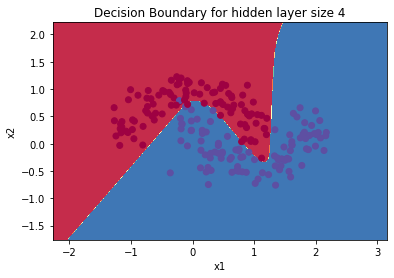

In [96]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [97]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 99%
